<a href="https://colab.research.google.com/github/Harsh-Gehlot/BInary_Image_Classsification/blob/main/Classification_man_woman.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [10]:
 ! pip install -q kaggle

In [11]:
 ! mkdir ~/.kaggle

mkdir: cannot create directory ‘/root/.kaggle’: File exists


In [12]:
! cp kaggle.json ~/.kaggle/

In [13]:
! chmod 600 ~/.kaggle/kaggle.json

In [14]:
!kaggle datasets download -d gmlmrinalini/manwomandetection

 92% 126M/138M [00:01<00:00, 66.7MB/s]
100% 138M/138M [00:01<00:00, 90.8MB/s]


In [15]:
!unzip -q manwomandetection.zip

In [16]:
import tensorflow as tf
from tensorflow import keras

In [17]:
from tensorflow.keras import layers

In [18]:
image_size = (180, 180)
batch_size = 32

train_ds = tf.keras.preprocessing.image_dataset_from_directory(
    "dataset/dataset/train",
    validation_split=0.2,
    subset="training",
    seed=1337,
    image_size=image_size,
    batch_size=batch_size,
)
val_ds = tf.keras.preprocessing.image_dataset_from_directory(
    "dataset/dataset/train",
    validation_split=0.2,
    subset="validation",
    seed=1337,
    image_size=image_size,
    batch_size=batch_size,
)

Found 1615 files belonging to 2 classes.
Using 1292 files for training.
Found 1615 files belonging to 2 classes.
Using 323 files for validation.


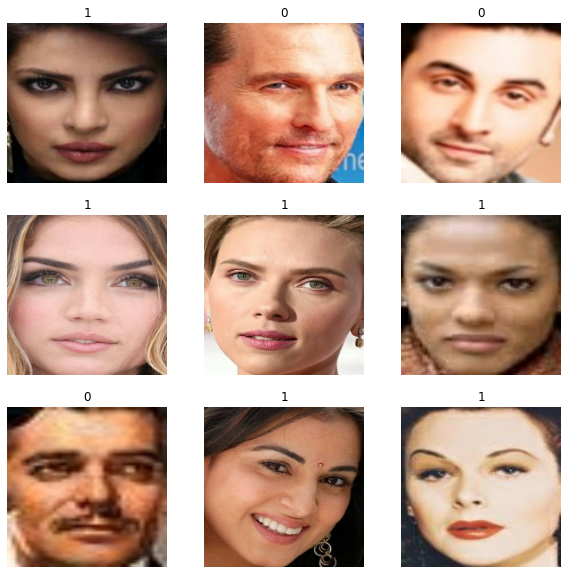

In [19]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 10))
for images, labels in train_ds.take(1):
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        plt.title(int(labels[i]))
        plt.axis("off")

In [20]:
data_augmentation = keras.Sequential(
    [
        layers.experimental.preprocessing.RandomFlip("horizontal"),
        layers.experimental.preprocessing.RandomRotation(0.1),
    ]
)

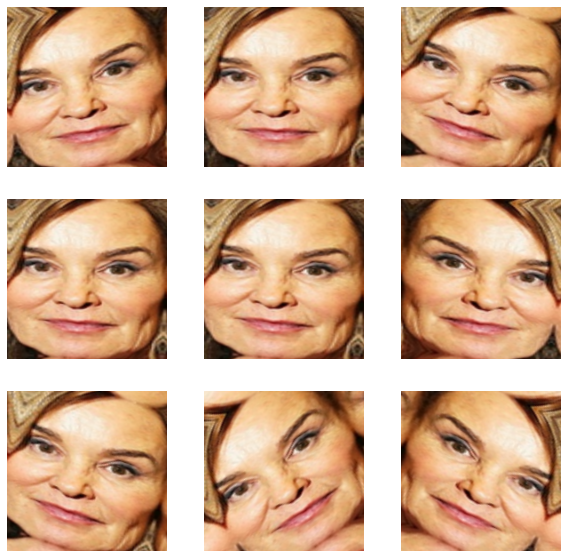

In [21]:
plt.figure(figsize=(10, 10))
for images, _ in train_ds.take(1):
    for i in range(9):
        augmented_images = data_augmentation(images)
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(augmented_images[0].numpy().astype("uint8"))
        plt.axis("off")

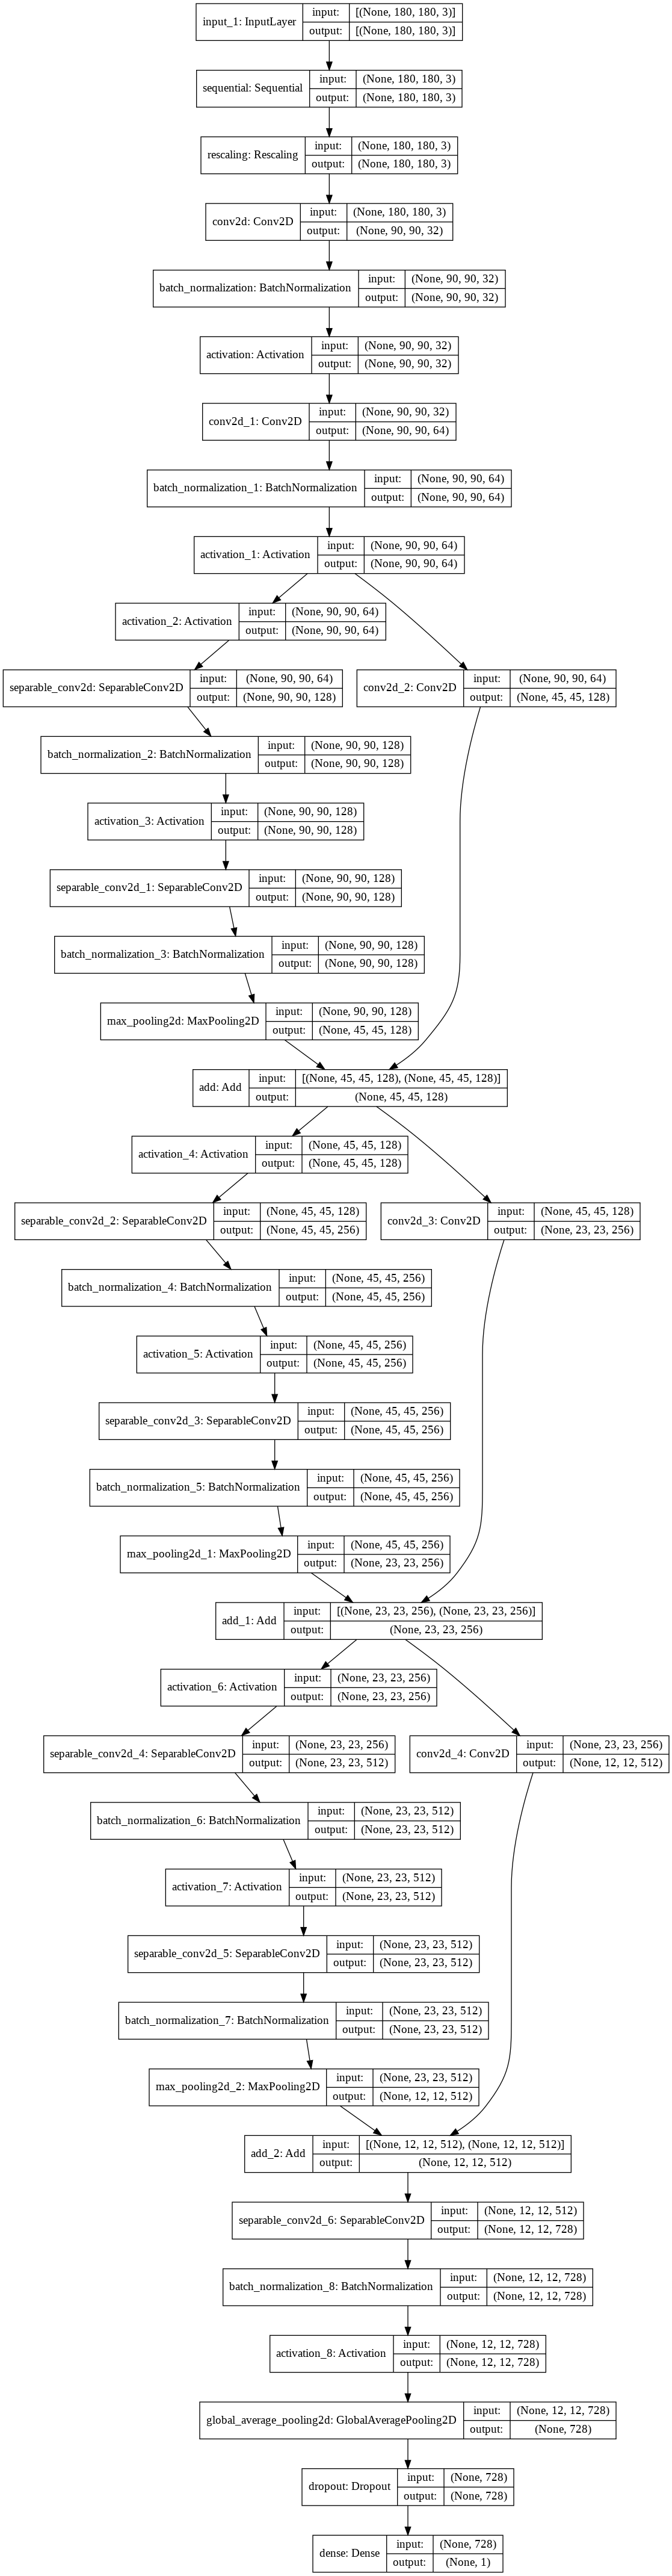

In [22]:
def make_model(input_shape, num_classes):
    inputs = keras.Input(shape=input_shape)
    # Image augmentation block
    x = data_augmentation(inputs)

    # Entry block
    x = layers.experimental.preprocessing.Rescaling(1.0 / 255)(x)
    x = layers.Conv2D(32, 3, strides=2, padding="same")(x)
    x = layers.BatchNormalization()(x)
    x = layers.Activation("relu")(x)

    x = layers.Conv2D(64, 3, padding="same")(x)
    x = layers.BatchNormalization()(x)
    x = layers.Activation("relu")(x)

    previous_block_activation = x  # Set aside residual

    for size in [128, 256, 512]:
        x = layers.Activation("relu")(x)
        x = layers.SeparableConv2D(size, 3, padding="same")(x)
        x = layers.BatchNormalization()(x)

        x = layers.Activation("relu")(x)
        x = layers.SeparableConv2D(size, 3, padding="same")(x)
        x = layers.BatchNormalization()(x)

        x = layers.MaxPooling2D(3, strides=2, padding="same")(x)

        # Project residual
        residual = layers.Conv2D(size, 1, strides=2, padding="same")(
            previous_block_activation
        )
        x = layers.add([x, residual])  # Add back residual
        previous_block_activation = x  # Set aside next residual

    x = layers.SeparableConv2D(728, 3, padding="same")(x)
    x = layers.BatchNormalization()(x)
    x = layers.Activation("relu")(x)

    x = layers.GlobalAveragePooling2D()(x)
    if num_classes == 2:
        activation = "sigmoid"
        units = 1
    else:
        activation = "softmax"
        units = num_classes

    x = layers.Dropout(0.5)(x)
    outputs = layers.Dense(units, activation=activation)(x)
    return keras.Model(inputs, outputs)


model = make_model(input_shape=image_size + (3,), num_classes=2)
keras.utils.plot_model(model, show_shapes=True)

In [23]:
epochs = 50

callbacks = [
    keras.callbacks.ModelCheckpoint("save_at_{epoch}.h5"),
]
model.compile(
    optimizer=keras.optimizers.Adam(1e-3),
    loss="binary_crossentropy",
    metrics=["accuracy"],
)
model.fit(
    train_ds, epochs=epochs, callbacks=callbacks, validation_data=val_ds,
)

Epoch 1/50
41/41 [==============================] - 54s 557ms/step - loss: 0.6159 - accuracy: 0.6765 - val_loss: 0.7025 - val_accuracy: 0.4706


/usr/local/lib/python3.7/dist-packages/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


Epoch 2/50
41/41 [==============================] - 21s 500ms/step - loss: 0.4579 - accuracy: 0.7995 - val_loss: 0.7179 - val_accuracy: 0.4706
Epoch 3/50
41/41 [==============================] - 20s 493ms/step - loss: 0.3746 - accuracy: 0.8390 - val_loss: 0.7448 - val_accuracy: 0.4706
Epoch 4/50
41/41 [==============================] - 21s 496ms/step - loss: 0.3151 - accuracy: 0.8684 - val_loss: 0.7863 - val_accuracy: 0.4706
Epoch 5/50
41/41 [==============================] - 21s 498ms/step - loss: 0.2092 - accuracy: 0.9056 - val_loss: 0.8515 - val_accuracy: 0.4706
Epoch 6/50
41/41 [==============================] - 21s 497ms/step - loss: 0.1601 - accuracy: 0.9412 - val_loss: 0.9454 - val_accuracy: 0.4706
Epoch 7/50
41/41 [==============================] - 21s 498ms/step - loss: 0.1539 - accuracy: 0.9404 - val_loss: 1.0929 - val_accuracy: 0.4706
Epoch 8/50
41/41 [==============================] - 21s 496ms/step - loss: 0.1296 - accuracy: 0.9536 - val_loss: 0.8685 - val_accuracy: 0.4706

In [25]:
# from google.colab import drive
# drive.mount('/content/gdrive')

In [ ]:
# model.save('gdrive/MyDrive/kagglecatsanddogs_3367a/Classifier-Model-2')

In [ ]:
# from tensorflow import keras
# my_model = keras.models.load_model('gdrive/MyDrive/kagglecatsanddogs_3367a/Classifier-Model-2')

In [ ]:
!git init